In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import torch
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/homes10/klkehl/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mimic0 = pd.read_csv('../data/first_half_discharges.csv')
mimic1 = pd.read_csv('../data/second_half_discharges.csv')
mimic = pd.concat([mimic0,mimic1], axis=0)



In [3]:
mimic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141377 entries, 0 to 70688
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       141377 non-null  int64  
 1   note_id          141377 non-null  object 
 2   subject_id       141377 non-null  int64  
 3   hadm_id          141377 non-null  int64  
 4   note_type        141377 non-null  object 
 5   note_seq         141377 non-null  int64  
 6   charttime        141377 non-null  object 
 7   storetime        141375 non-null  object 
 8   text             141377 non-null  object 
 9   outcome_0_logit  141377 non-null  float64
 10  outcome_1_logit  141377 non-null  float64
 11  outcome_2_logit  141377 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 14.0+ MB


In [4]:
mimic = mimic.rename(columns={'outcome_0_logit':'any_cancer_logit',
                              'outcome_1_logit':'response_logit',
                              'outcome_2_logit':'progression_logit'})

In [5]:
phi_data = pd.read_csv('/data/clin_notes_outcomes/profile_3-2023/derived_data/labeled_medonc_prissmm_mixedisprog.csv')



In [ ]:
validation = phi_data[phi_data.split=='validation']

#validation.head()


In [7]:

from transformers import AutoModel



from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, Dropout, Module, Sequential, ReLU

   
class LabeledModel(nn.Module):

    def __init__(self):
        super(LabeledModel, self).__init__()
        
        self.longformer = AutoModel.from_pretrained('yikuan8/Clinical-Longformer')
        
        self.any_cancer_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.response_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.progression_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))


        
    def forward(self, x_text_tensor, x_attention_mask):
        # x should be tuple of input IDs, then attention mask
        global_attention_mask = torch.zeros_like(x_text_tensor).to('cuda')
        # global attention on cls token
        global_attention_mask[:, 0] = 1
        main = self.longformer(x_text_tensor, x_attention_mask, global_attention_mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)

                                          
        any_cancer_out = self.any_cancer_head(main)
        response_out = self.response_head(main)
        progression_out = self.progression_head(main)



        
        return any_cancer_out, response_out, progression_out
        




In [11]:
from torch.utils import data

class PseudoLabeledDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset.copy()
        self.indices = self.data.index.unique()
        self.tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer", truncation_side='right')        
        
        
    def __len__(self):
        # how many notes in the dataset
        return len(self.indices)
    
    def __getitem__(self, index):
        # get data for notes corresponding to indices passed
        this_index = self.indices[index]
        pand = self.data.loc[this_index, :]
        #label = torch.tensor(pand.progression, dtype=torch.float32)
    
        encoded = self.tokenizer(pand['text'], padding='max_length', truncation=True)

        x_text_tensor = torch.tensor(encoded.input_ids, dtype=torch.long)
        x_attention_mask = torch.tensor(encoded.attention_mask, dtype=torch.long)
        
        #y_class_status = torch.tensor(pand.class_status, dtype=torch.long)

        outcome_vars = [pand.any_cancer_logit, pand.response_logit, pand.progression_logit]
        return x_text_tensor, x_attention_mask, *tuple(outcome_vars)
        
        

In [14]:
from torch.utils import data

class LabeledDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset.copy()
        self.indices = self.data.index.unique()
        self.tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer", truncation_side='left')        
        
        
    def __len__(self):
        # how many notes in the dataset
        return len(self.indices)
    
    def __getitem__(self, index):
        # get data for notes corresponding to indices passed
        this_index = self.indices[index]
        pand = self.data.loc[this_index, :]
        #label = torch.tensor(pand.progression, dtype=torch.float32)
    
        encoded = self.tokenizer(pand['text'], padding='max_length', truncation=True)

        x_text_tensor = torch.tensor(encoded.input_ids, dtype=torch.long)
        x_attention_mask = torch.tensor(encoded.attention_mask, dtype=torch.long)
        
        y_any_cancer = torch.tensor(pand.any_cancer, dtype=torch.float32)
        y_response = torch.tensor(pand.response, dtype=torch.float32)
        y_progression = torch.tensor(pand.progression, dtype=torch.float32)
        


        return x_text_tensor, x_attention_mask, y_any_cancer, y_response, y_progression
        
        

In [15]:
device = 'cuda'

In [16]:
# train loop
from transformers import get_scheduler
from torch.optim import AdamW, Adam
#, get_linear_schedule_with_warmup


def train_model(model, num_epochs, trainloader, validloader=None, device='cuda'):
    
    

    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    num_training_steps = num_epochs * len(trainloader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    model.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_train_losses = [0.0 for i in range(3)]
        mean_train_losses = [0.0 for i in range(3)]
        
        running_valid_losses = [0.0 for i in range(3)]
        mean_valid_losses = [0.0 for i in range(3)]

        num_train_batches = len(trainloader)
                
        model.train()
        
        for i, batch in enumerate(trainloader, 0):
            input_ids = batch[0].to(device)
            input_masks = batch[1].to(device)
            
            optimizer.zero_grad()
            
            outputs_true = [x.to(device) for x in batch[2:]]
            
            outputs_pred = model(input_ids, input_masks)
            
           
            losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), torch.sigmoid(outputs_true[x])) for x in range(3)]
            
            total_loss = 0.0
            for j in range(3):
                total_loss = total_loss + losses[j]

                
            total_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            
            
            for j in range(3):
                running_train_losses[j] += losses[j].detach().cpu().numpy()
                mean_train_losses[j] = running_train_losses[j] / (i+1)
                
            print('Training Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ' this_loss:' + str(total_loss.detach().cpu().numpy()) +', train losses: ' + str([str(x) + ': ' + str(mean_train_losses[x]) + ", " for x in range(3)]), end='\r', flush=True)
        
        print('\n')
        # eval on valid
        
        if validloader is not None:
            num_valid_batches = len(validloader)
            model.eval()
            
            for i, batch in enumerate(validloader, 0):
                input_ids = batch[0].to(device)
                input_masks = batch[1].to(device)


                outputs_true = [x.to(device) for x in batch[2:]]

                outputs_pred = model(input_ids, input_masks)

                losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), torch.sigmoid(outputs_true[x])) for x in range(3)]

                total_loss = 0.0
                for j in range(3):
                    total_loss = total_loss + losses[j]
                


                for j in range(3):
                    running_valid_losses[j] += losses[j].detach().cpu().numpy()

            
            for j in range(3):
                mean_valid_losses[j] = running_valid_losses[j] / (i+1)
            

            
            print('Validation Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_valid_batches) + ', valid losses: ' + str([str(x) + ': ' + str(mean_valid_losses[x]) + ", " for x in range(10)]), end='\r', flush=True)
            print('\n')

    

In [18]:
# actual training

# themodel = LabeledModel().to('cuda')
# trainloader = data.DataLoader(PseudoLabeledDataset(mimic.reset_index(drop=True)), batch_size=8, num_workers=8, shuffle=True)
# validloader = data.DataLoader(LabeledDataset(validation.reset_index(drop=True)), batch_size=4, num_workers=8, shuffle=True)
# train_model(themodel,1, trainloader, validloader, device='cuda')

# torch.save(themodel.state_dict(), 'dfci_mimic_note_longformer.pt')

In [19]:
# write out actual validation dataset
themodel = LabeledModel()
themodel.load_state_dict(torch.load('dfci_mimic_note_longformer.pt'))
themodel.to('cuda')

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(LabeledDataset(validation), batch_size=8, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(3)]
output_prediction_lists = [[] for x in range(3)]
for batch in no_shuffle_valid_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to('cuda')
    x_attention_mask = batch[1].to('cuda')
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(3):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_validation = validation.copy()
for x in range(3):
    output_validation['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]



Some weights of the model checkpoint at yikuan8/Clinical-Longformer were not used when initializing LongformerModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a dow

In [21]:
from sklearn.metrics import roc_auc_score


In [22]:
[print(roc_auc_score(output_true_lists[x], output_prediction_lists[x])) for x in range(3)]

0.958715691965079
0.9489462029004812
0.9472313296065864


[None, None, None]

In [23]:
from utils_102023 import *

AUC 0.958715691965079
Outcome probability: 0.8006050605060506
Average precision score: 0.99
Best F1: 0.9580431459147275


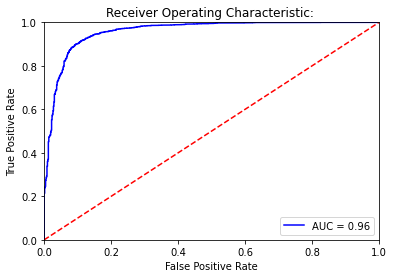

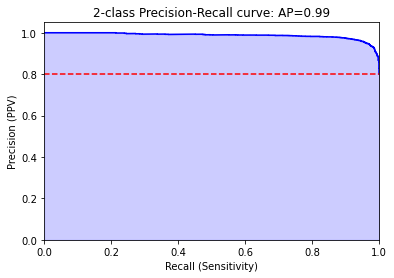

Threshold for best F1:
-0.12687403
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[ 569  156]
 [  91 2820]]


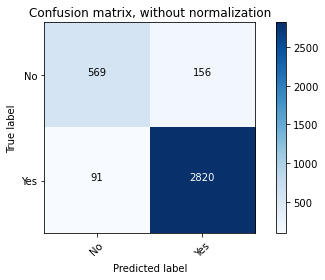

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.86      0.78      0.82       725
         Yes       0.95      0.97      0.96      2911

    accuracy                           0.93      3636
   macro avg       0.90      0.88      0.89      3636
weighted avg       0.93      0.93      0.93      3636

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[ 595  130]
 [ 131 2780]]


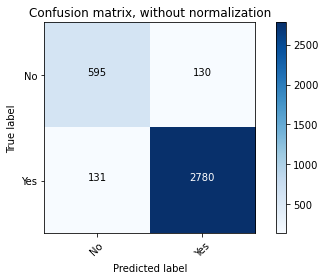

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.82      0.82      0.82       725
         Yes       0.96      0.95      0.96      2911

    accuracy                           0.93      3636
   macro avg       0.89      0.89      0.89      3636
weighted avg       0.93      0.93      0.93      3636



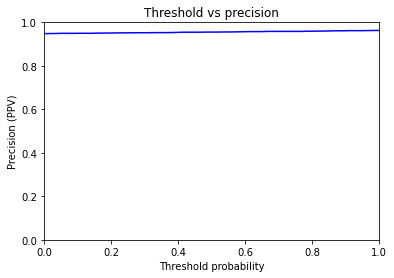

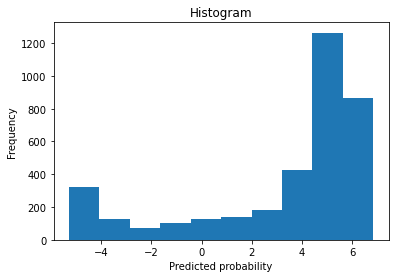

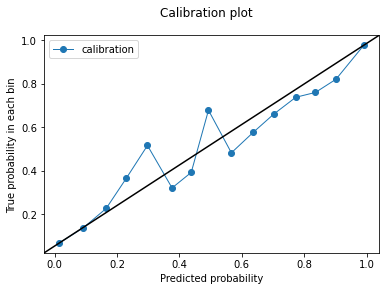

-0.12687403

In [24]:
eval_model(output_prediction_lists[0], output_true_lists[0], graph=True)

AUC 0.9489462029004812
Outcome probability: 0.13063806380638063
Average precision score: 0.75
Best F1: 0.7332686711930165


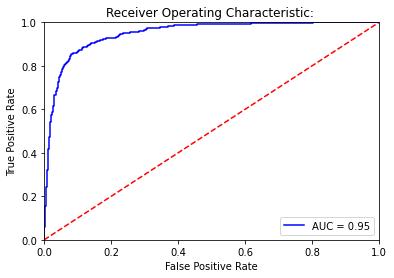

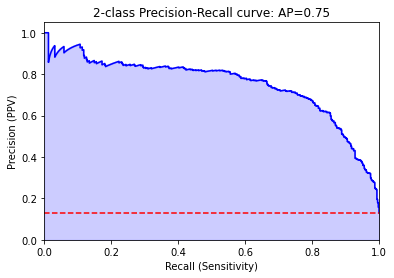

Threshold for best F1:
0.2692009
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2983  178]
 [  97  378]]


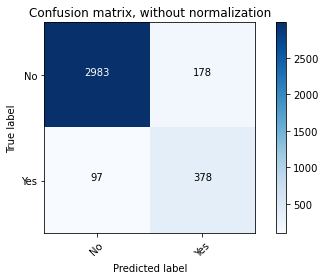

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.97      0.94      0.96      3161
         Yes       0.68      0.80      0.73       475

    accuracy                           0.92      3636
   macro avg       0.82      0.87      0.84      3636
weighted avg       0.93      0.92      0.93      3636

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[3001  160]
 [ 110  365]]


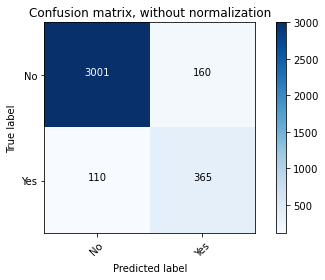

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.96      0.95      0.96      3161
         Yes       0.70      0.77      0.73       475

    accuracy                           0.93      3636
   macro avg       0.83      0.86      0.84      3636
weighted avg       0.93      0.93      0.93      3636



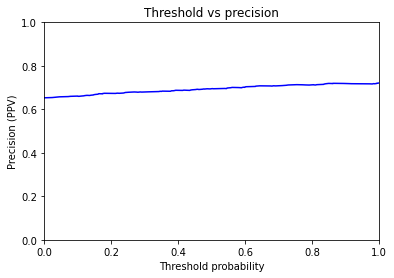

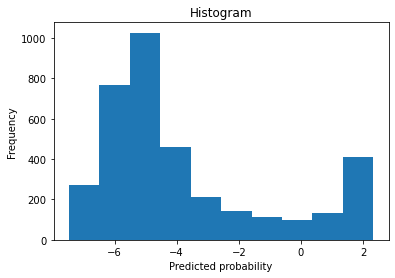

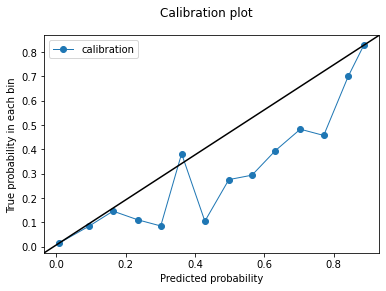

0.2692009

In [25]:
eval_model(output_prediction_lists[1], output_true_lists[1], graph=True)

AUC 0.9472313296065864
Outcome probability: 0.1806930693069307
Average precision score: 0.84
Best F1: 0.7576687116564418


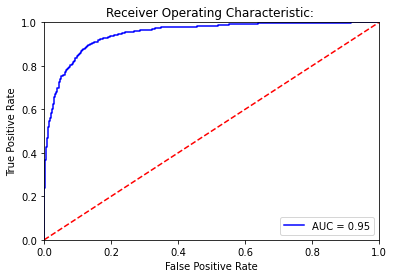

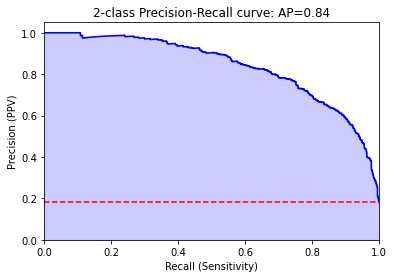

Threshold for best F1:
0.02193658
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2826  153]
 [ 163  494]]


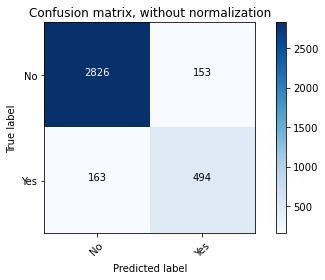

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.95      0.95      0.95      2979
         Yes       0.76      0.75      0.76       657

    accuracy                           0.91      3636
   macro avg       0.85      0.85      0.85      3636
weighted avg       0.91      0.91      0.91      3636

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2862  117]
 [ 203  454]]


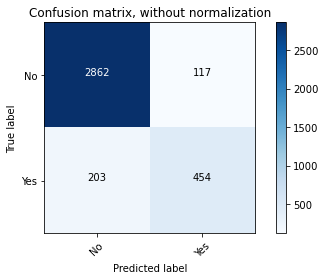

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.93      0.96      0.95      2979
         Yes       0.80      0.69      0.74       657

    accuracy                           0.91      3636
   macro avg       0.86      0.83      0.84      3636
weighted avg       0.91      0.91      0.91      3636



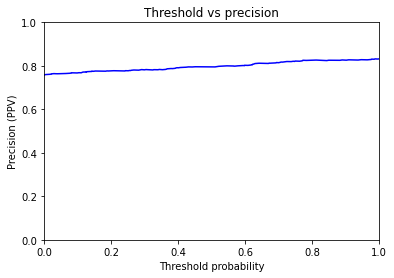

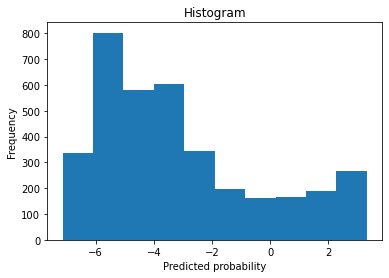

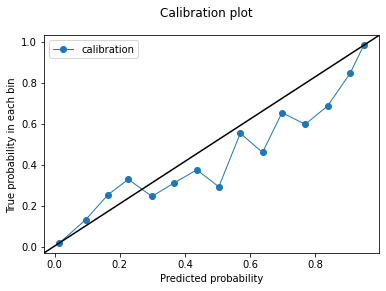

0.02193658

In [26]:
eval_model(output_prediction_lists[2], output_true_lists[2], graph=True)

In [29]:
test = phi_data[phi_data.split == 'test']
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 57 to 39088
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              3382 non-null   int64  
 1   dfci_mrn                  3382 non-null   float64
 2   cancer_type               3382 non-null   object 
 3   date                      3382 non-null   object 
 4   any_cancer                3382 non-null   int64  
 5   progression               3382 non-null   int64  
 6   response                  3382 non-null   int64  
 7   Unnamed: 0                3382 non-null   int64  
 8   text                      3382 non-null   object 
 9   PROVIDER_DEPARTMENT       3382 non-null   object 
 10  patient_id                3382 non-null   int64  
 11  hybrid_death_ind          3382 non-null   object 
 12  hybrid_death_dt           2160 non-null   object 
 13  primary_cancer_diagnosis  3382 non-null   object 
 14  genomi

In [30]:
# write out actual test dataset
themodel = LabeledModel()
themodel.load_state_dict(torch.load('dfci_mimic_note_longformer.pt'))
themodel.to('cuda')

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(LabeledDataset(test), batch_size=8, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(3)]
output_prediction_lists = [[] for x in range(3)]
for batch in no_shuffle_valid_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to('cuda')
    x_attention_mask = batch[1].to('cuda')
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(3):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_test = test.copy()
for x in range(3):
    output_test['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]



Some weights of the model checkpoint at yikuan8/Clinical-Longformer were not used when initializing LongformerModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a dow

AUC 0.9486274319452473
Outcome probability: 0.8024837374334713
Average precision score: 0.98
Best F1: 0.9603636363636364


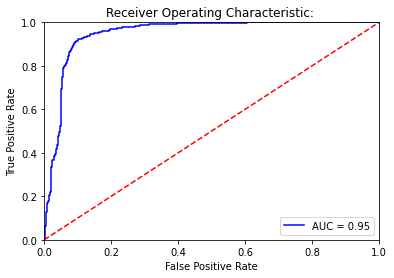

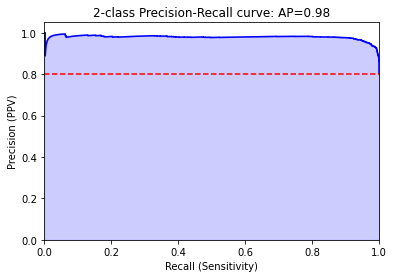

Threshold for best F1:
-0.092591725
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[ 523  145]
 [  73 2641]]


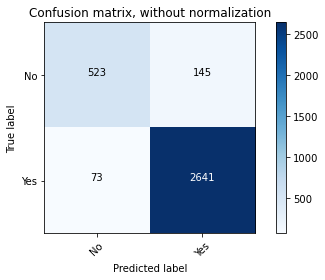

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.88      0.78      0.83       668
         Yes       0.95      0.97      0.96      2714

    accuracy                           0.94      3382
   macro avg       0.91      0.88      0.89      3382
weighted avg       0.93      0.94      0.93      3382

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[ 547  121]
 [ 108 2606]]


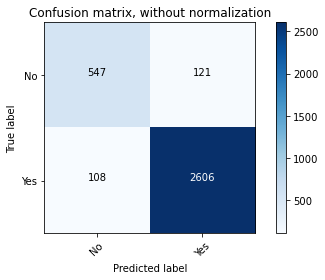

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.84      0.82      0.83       668
         Yes       0.96      0.96      0.96      2714

    accuracy                           0.93      3382
   macro avg       0.90      0.89      0.89      3382
weighted avg       0.93      0.93      0.93      3382



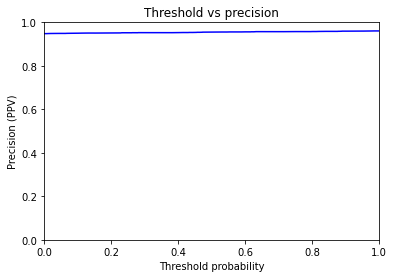

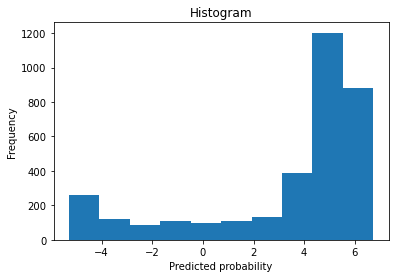

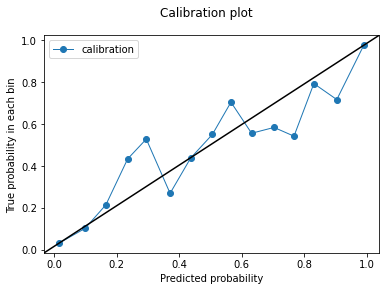

-0.092591725

In [31]:
eval_model(output_prediction_lists[0], output_true_lists[0], graph=True)

AUC 0.9542119210241482
Outcome probability: 0.11975162625665287
Average precision score: 0.79
Best F1: 0.7561576354679802


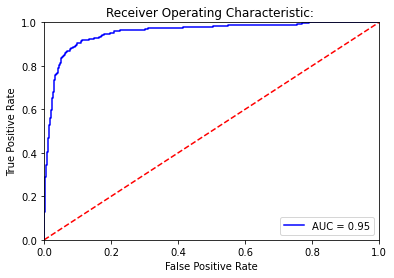

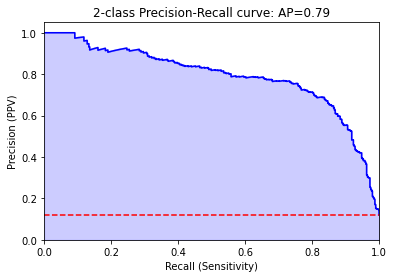

Threshold for best F1:
1.1217427
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2877  100]
 [  98  307]]


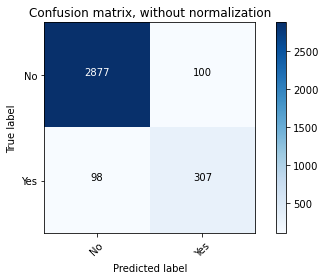

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.97      0.97      0.97      2977
         Yes       0.75      0.76      0.76       405

    accuracy                           0.94      3382
   macro avg       0.86      0.86      0.86      3382
weighted avg       0.94      0.94      0.94      3382

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2823  154]
 [  66  339]]


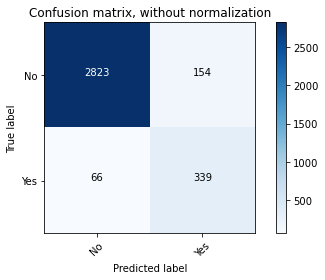

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.95      0.96      2977
         Yes       0.69      0.84      0.76       405

    accuracy                           0.93      3382
   macro avg       0.83      0.89      0.86      3382
weighted avg       0.94      0.93      0.94      3382



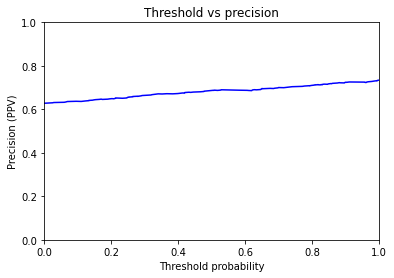

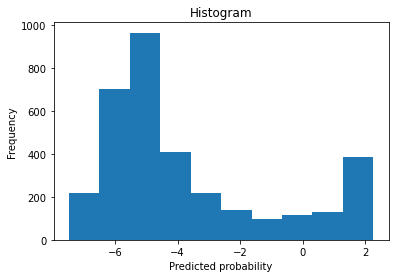

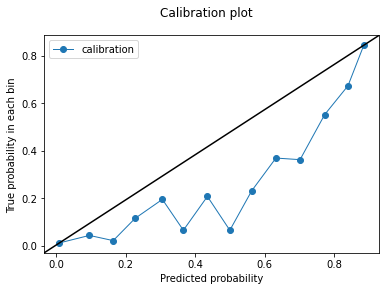

1.1217427

In [32]:
eval_model(output_prediction_lists[1], output_true_lists[1], graph=True)

AUC 0.9530369450442853
Outcome probability: 0.17060910703725607
Average precision score: 0.82
Best F1: 0.7788378143972245


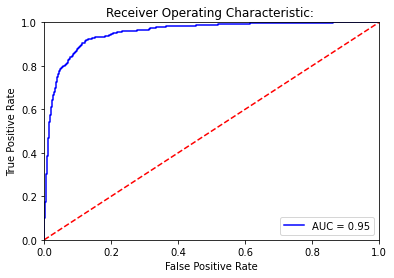

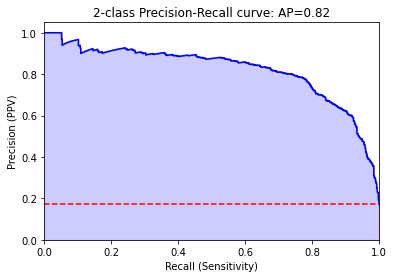

Threshold for best F1:
-0.005885735
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2678  127]
 [ 128  449]]


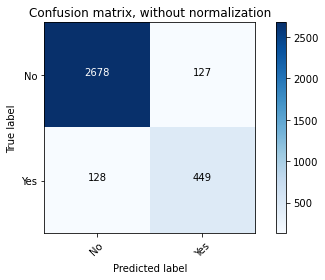

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.95      0.95      0.95      2805
         Yes       0.78      0.78      0.78       577

    accuracy                           0.92      3382
   macro avg       0.87      0.87      0.87      3382
weighted avg       0.92      0.92      0.92      3382

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2709   96]
 [ 169  408]]


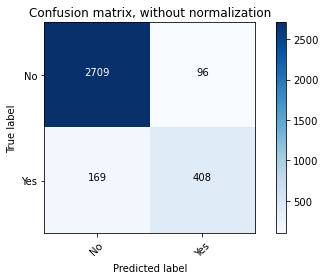

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.94      0.97      0.95      2805
         Yes       0.81      0.71      0.75       577

    accuracy                           0.92      3382
   macro avg       0.88      0.84      0.85      3382
weighted avg       0.92      0.92      0.92      3382



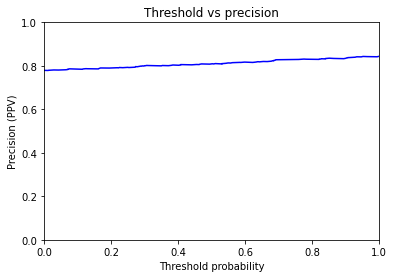

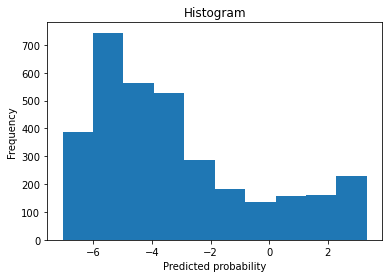

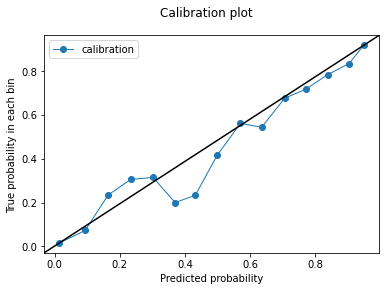

-0.005885735

In [33]:
eval_model(output_prediction_lists[2], output_true_lists[2], graph=True)